In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from tqdm import tqdm
import datetime

from keras.layers import BatchNormalization, Dropout, LSTM, Dense, Flatten, MaxPooling1D
from keras.layers import ConvLSTM2D, Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, MaxPooling1D

from keras.callbacks import EarlyStopping


import tensorflow as tf


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [271]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

merge_df = pd.DataFrame(index = range(5783))

for each in regions:
    df = pd.read_csv('{}_iso.csv'.format(each))
    df.drop(columns = ['Date'], inplace=True)

                        
    for i in df.columns:
        df[i] = df[i].fillna(method='ffill')
    
    merge_df = pd.concat([merge_df, df], axis = 1)


In [272]:
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]
count_regions = ['Count_{}'.format(i) for i in regions]
sqrt_fire_regions = ['sqrt_{}'.format(i) for i in fire_regions]
sqrt_count_regions = ['sqrt_Count_{}'.format(i) for i in regions]

merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)
merge_df['Date'] = pd.date_range(start = '2005-01-01', end = '2020-10-31')
merge_df.set_index('Date', inplace=True)

for i,x in zip(fire_regions, count_regions):
    merge_df['sqrt_{}'.format(i)] = np.sqrt(merge_df[i])
    merge_df['sqrt_{}'.format(x)] = np.sqrt(merge_df[i]/merge_df[x]) * merge_df[x]
    
merge_df.fillna(0, inplace=True)



In [273]:
sqrt_count_regions

['sqrt_Count_NSW',
 'sqrt_Count_NT',
 'sqrt_Count_QL',
 'sqrt_Count_SA',
 'sqrt_Count_TA',
 'sqrt_Count_VI',
 'sqrt_Count_WA']

In [274]:
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)

In [275]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.00000,4.945000,38.831579,0.0,0.0,0.0,36.382500,0.0,0.044274,36.355567,...,6.231499,27.162474,0.0,0.0,0.0,0.0,0.000000,0.00000,6.031791,24.127163
2005-01-02,0.00000,1.320000,64.464286,0.0,0.0,2.8,148.106471,0.0,0.173879,38.699607,...,8.028965,42.485292,0.0,0.0,0.0,0.0,1.673320,1.67332,12.169900,70.962103
2005-01-03,0.00000,88.740000,47.386585,0.0,0.0,1.0,60.632258,0.0,3.011912,49.365152,...,6.883791,44.077772,0.0,0.0,0.0,0.0,1.000000,1.00000,7.786672,43.354354
2005-01-04,8.68000,0.000000,30.100000,0.0,0.0,0.0,86.374167,3.0,2.808620,57.095628,...,5.486347,26.877500,0.0,0.0,0.0,0.0,0.000000,0.00000,9.293770,55.762622
2005-01-05,16.61125,0.000000,4.000000,0.0,0.0,0.0,31.378947,8.0,0.157935,47.170735,...,2.000000,4.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,5.601691,24.417207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,1.21000,12.750000,78.670769,0.0,0.0,0.0,32.970000,1.0,2.124025,65.191496,...,8.869654,71.509440,0.0,0.0,0.0,0.0,0.000000,0.00000,5.741951,19.043897
2020-10-28,3.00000,144.990566,119.608649,0.0,0.0,2.0,20.840625,3.0,4.350241,65.642208,...,10.936574,66.524582,0.0,0.0,0.0,0.0,1.414214,2.00000,4.565153,18.260613
2020-10-29,0.00000,53.462326,249.090625,0.0,0.0,0.0,136.083077,0.0,2.342508,59.019745,...,15.782605,218.690192,0.0,0.0,0.0,0.0,0.000000,0.00000,11.665465,72.850806


In [276]:
# for i in fire_regions + count_regions + sqrt_fire_regions + sqrt_count_regions:
#     merge_df[i] = np.log1p(merge_df[i])

In [277]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.00000,4.945000,38.831579,0.0,0.0,0.0,36.382500,0.0,0.044274,36.355567,...,6.231499,27.162474,0.0,0.0,0.0,0.0,0.000000,0.00000,6.031791,24.127163
2005-01-02,0.00000,1.320000,64.464286,0.0,0.0,2.8,148.106471,0.0,0.173879,38.699607,...,8.028965,42.485292,0.0,0.0,0.0,0.0,1.673320,1.67332,12.169900,70.962103
2005-01-03,0.00000,88.740000,47.386585,0.0,0.0,1.0,60.632258,0.0,3.011912,49.365152,...,6.883791,44.077772,0.0,0.0,0.0,0.0,1.000000,1.00000,7.786672,43.354354
2005-01-04,8.68000,0.000000,30.100000,0.0,0.0,0.0,86.374167,3.0,2.808620,57.095628,...,5.486347,26.877500,0.0,0.0,0.0,0.0,0.000000,0.00000,9.293770,55.762622
2005-01-05,16.61125,0.000000,4.000000,0.0,0.0,0.0,31.378947,8.0,0.157935,47.170735,...,2.000000,4.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,5.601691,24.417207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,1.21000,12.750000,78.670769,0.0,0.0,0.0,32.970000,1.0,2.124025,65.191496,...,8.869654,71.509440,0.0,0.0,0.0,0.0,0.000000,0.00000,5.741951,19.043897
2020-10-28,3.00000,144.990566,119.608649,0.0,0.0,2.0,20.840625,3.0,4.350241,65.642208,...,10.936574,66.524582,0.0,0.0,0.0,0.0,1.414214,2.00000,4.565153,18.260613
2020-10-29,0.00000,53.462326,249.090625,0.0,0.0,0.0,136.083077,0.0,2.342508,59.019745,...,15.782605,218.690192,0.0,0.0,0.0,0.0,0.000000,0.00000,11.665465,72.850806


In [278]:
train = merge_df[:'2019-10-31']
test = merge_df['2019-11-01':'2020-03-02']

In [279]:
test.shape

(123, 77)

In [280]:

tf.keras.backend.clear_session()

In [281]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(train)
_train = scaler.transform(train)
_train.shape

(5417, 77)

In [282]:

def split_sequence(sequences, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(0, len(sequences), 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, :7]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [283]:
n_steps_in, n_steps_out = 123, 123

In [284]:
X, y = split_sequence(_train, n_steps_in, n_steps_out)
y.shape

(5172, 123, 7)

In [285]:
X.shape

(5172, 123, 77)

In [286]:
# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

In [287]:
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]

In [288]:
y.shape

(5172, 861)

In [289]:
n_output

861

In [290]:
X_train, y_train = X[:-365,:,:], y[:-365,:]
X_valid, y_valid = X[-365:, :, :], y[-365:, :]

In [98]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)

    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)
pred_seq_train = Dense(n_output, activation = 'relu')(out)

model = Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-6)

model.compile(optimizer, loss= tf.keras.losses.Poisson(), metrics = ['mae'])

In [99]:
history = model.fit(X_train, y_train, epochs = 100, callbacks = [lr_schedule], validation_data = (X_valid, y_valid))

Epoch 1/100
151/151 [==============================] - 13s 85ms/step - loss: 2.8052 - mae: 0.2761 - val_loss: 3.2244 - val_mae: 0.3140
Epoch 2/100
151/151 [==============================] - 11s 74ms/step - loss: 2.7820 - mae: 0.2759 - val_loss: 3.1963 - val_mae: 0.3138
Epoch 3/100
151/151 [==============================] - 12s 82ms/step - loss: 2.7638 - mae: 0.2756 - val_loss: 3.1703 - val_mae: 0.3135
Epoch 4/100
 18/151 [==>...........................] - ETA: 9s - loss: 2.7480 - mae: 0.2750

KeyboardInterrupt: 

In [359]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, .5]);

KeyError: 'lr'

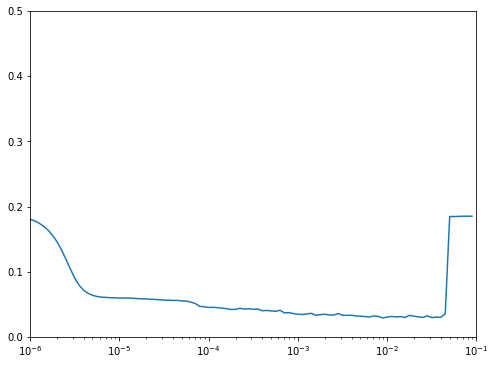

In [355]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e-1, 0, .5]);

In [291]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))


# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)

out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)


pred_seq_train = Dense(n_output, activation = 'relu')(out)
model = Model(history_seq, pred_seq_train)


optimizer = tf.keras.optimizers.Adam(lr = 1e-4
                                    )


model.compile(optimizer, loss=tf.keras.losses.Poisson(), metrics = ['mae'])

In [336]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid))

Epoch 1/100
151/151 [==============================] - 13s 85ms/step - loss: 0.0772 - mae: 0.0132 - val_loss: 0.0958 - val_mae: 0.0161
Epoch 2/100
151/151 [==============================] - 13s 87ms/step - loss: 0.0771 - mae: 0.0132 - val_loss: 0.0955 - val_mae: 0.0162
Epoch 3/100
151/151 [==============================] - 13s 83ms/step - loss: 0.0771 - mae: 0.0132 - val_loss: 0.0957 - val_mae: 0.0162
Epoch 4/100
151/151 [==============================] - 13s 84ms/step - loss: 0.0772 - mae: 0.0133 - val_loss: 0.0957 - val_mae: 0.0161
Epoch 5/100
151/151 [==============================] - 12s 80ms/step - loss: 0.0771 - mae: 0.0132 - val_loss: 0.0956 - val_mae: 0.0164
Epoch 6/100
151/151 [==============================] - 14s 93ms/step - loss: 0.0772 - mae: 0.0134 - val_loss: 0.0950 - val_mae: 0.0171
Epoch 7/100
151/151 [==============================] - 17s 116ms/step - loss: 0.0772 - mae: 0.0133 - val_loss: 0.0957 - val_mae: 0.0163
Epoch 8/100
151/151 [==============================] -

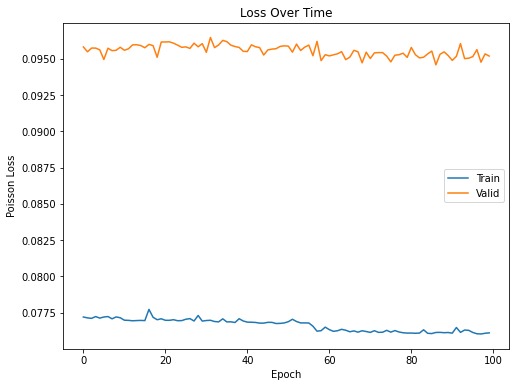

In [337]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [338]:
x_input = np.array(train.iloc[-123:].values)
x_input = scaler.transform(x_input)

In [339]:
x_input.shape

(123, 77)

In [340]:
x_input = x_input.reshape((1, n_steps_in, n_features))

In [341]:
yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 861)

In [342]:
yhat_df = pd.DataFrame(yhat.reshape(123,7), index = test.index, columns = fire_regions)

In [343]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2019-11-01,0.016898,0.078548,0.175990,0.028401,0.008094,0.002305,0.122362
2019-11-02,0.021288,0.074447,0.172916,0.029463,0.003102,0.001164,0.120803
2019-11-03,0.018767,0.073343,0.185941,0.029813,0.008036,0.010791,0.115922
2019-11-04,0.027373,0.072591,0.181935,0.035635,0.011052,0.008390,0.118654
2019-11-05,0.019427,0.073157,0.182930,0.028351,0.010296,0.005895,0.111672
...,...,...,...,...,...,...,...
2020-02-27,0.007302,0.001507,0.009138,0.006486,0.012807,0.009170,0.005806
2020-02-28,0.008128,0.001805,0.005810,0.002742,0.009695,0.007789,0.005311
2020-02-29,0.011482,0.000000,0.006989,0.004434,0.009412,0.004989,0.005679


In [344]:
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0

In [345]:
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [346]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,dummy_0,dummy_1,dummy_2,...,dummy_60,dummy_61,dummy_62,dummy_63,dummy_64,dummy_65,dummy_66,dummy_67,dummy_68,dummy_69
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,34.756349,794.975237,686.125630,47.087696,6.700489,4.790413,1034.117041,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-02,43.786498,753.478441,674.141477,48.848010,2.567459,2.419187,1020.940505,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-03,38.602069,742.296050,724.921525,49.428200,6.651940,22.422590,979.694163,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-04,56.302787,734.686362,709.301176,59.080369,9.148589,17.434097,1002.782460,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-05,39.957957,740.415779,713.182939,47.005347,8.522817,12.248226,943.773696,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27,15.018397,15.256749,35.627335,10.753572,10.601309,19.053971,49.066346,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-28,16.718994,18.273044,22.651058,4.545982,8.025445,16.183939,44.882756,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-29,23.617766,0.000000,27.246066,7.351773,7.791291,10.365521,47.998143,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
test

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,126.333187,68.370714,24.507143,0.000000,0.0,0.00,127.060357,91.0,0.646422,39.618650,...,4.950469,22.685899,0.000000,0.000000,0.0,0.0,0.00000,0.000000,11.272105,84.352712
2019-11-02,79.587368,103.395556,40.510833,11.597143,0.0,0.00,246.085714,57.0,6.345006,60.935982,...,6.364812,22.048356,3.405458,9.009994,0.0,0.0,0.00000,0.000000,15.687119,180.912686
2019-11-03,13.970000,45.084545,43.038667,4.680000,0.0,0.00,411.561429,12.0,10.946352,78.123328,...,6.560386,35.932715,2.163331,3.059412,0.0,0.0,0.00000,0.000000,20.286977,303.627667
2019-11-04,108.308571,10.412500,46.405882,0.000000,0.0,0.00,857.290658,35.0,0.807121,56.413287,...,6.812186,28.087364,0.000000,0.000000,0.0,0.0,0.00000,0.000000,29.279526,645.479093
2019-11-05,48.942121,23.124545,62.456333,20.750000,0.0,0.00,948.480000,33.0,0.144822,47.964062,...,7.902932,43.286141,4.555217,14.404860,0.0,0.0,0.00000,0.000000,30.797402,514.418040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27,7.911429,0.000000,1.430000,0.000000,0.0,0.00,19.152500,7.0,0.505206,45.087274,...,1.195826,1.195826,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.376357,15.160145
2020-02-28,5.508000,0.000000,9.293333,0.000000,1.0,3.30,0.000000,5.0,0.178557,48.498570,...,3.048497,7.467262,0.000000,0.000000,1.0,1.0,1.81659,3.146427,0.000000,0.000000
2020-02-29,13.000000,0.000000,22.995000,0.000000,0.0,3.36,0.000000,6.0,0.054360,47.417610,...,4.795310,16.611442,0.000000,0.000000,0.0,0.0,1.83303,2.592296,0.000000,0.000000


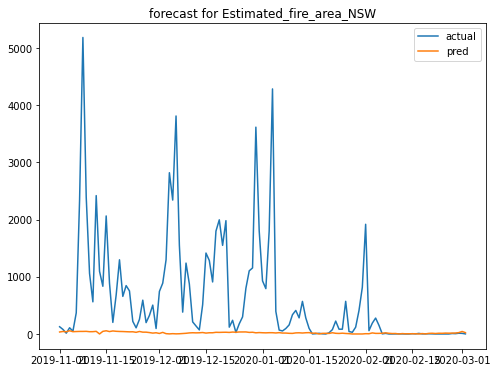

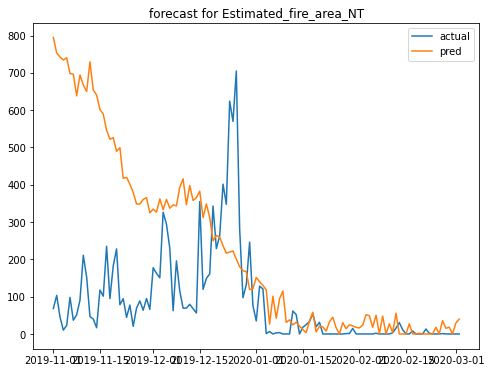

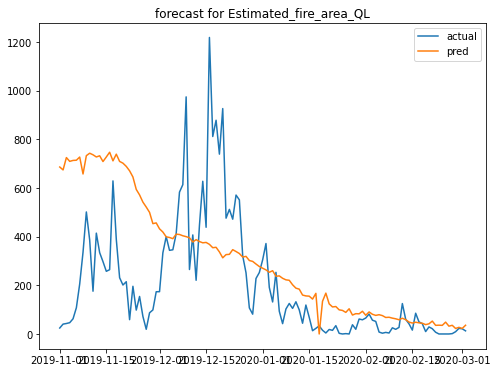

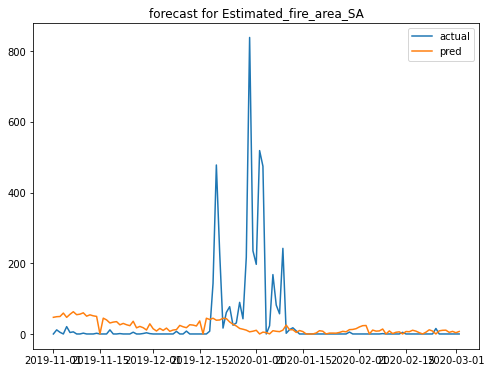

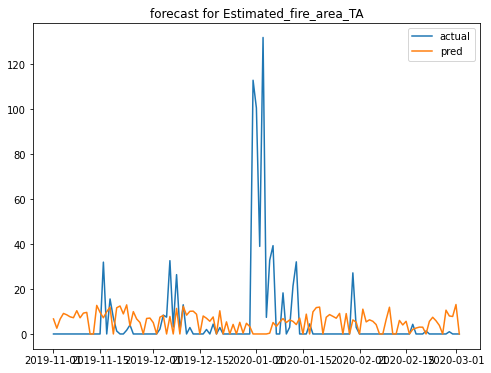

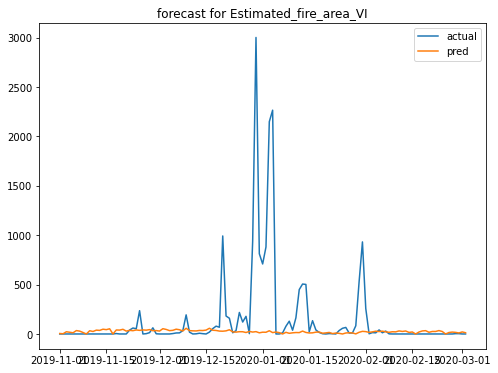

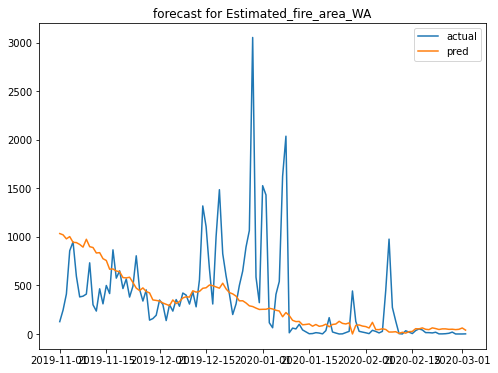

In [348]:
for i in fire_regions:

    plt.figure(figsize=(8,6))
    plt.plot(test[:'2020-03'][i], label = 'actual')
    plt.plot(yhat_df[:'2020-03'][i], label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

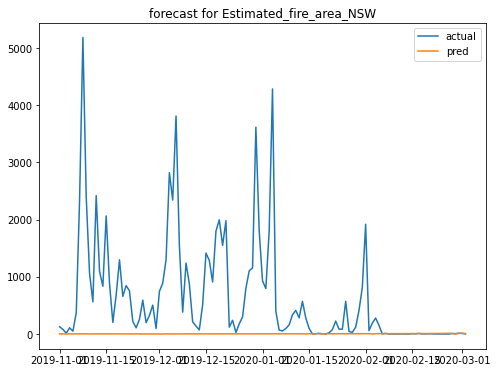

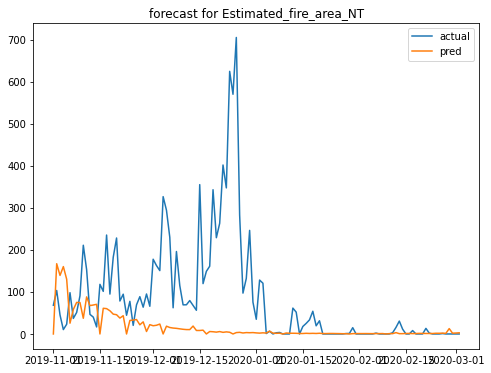

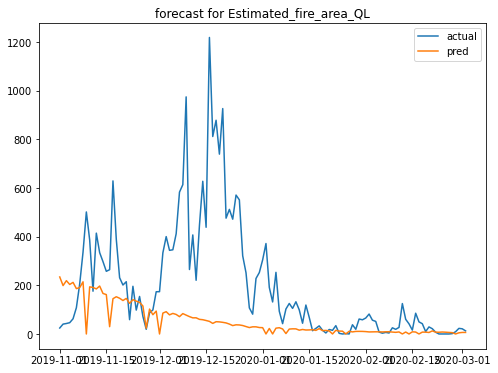

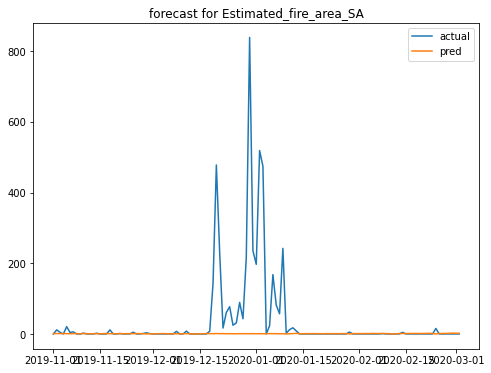

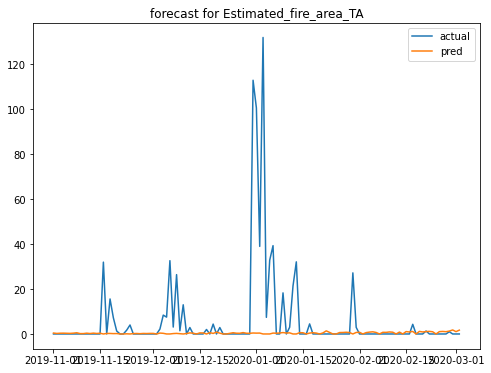

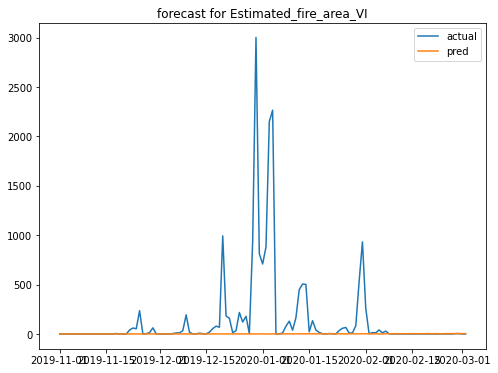

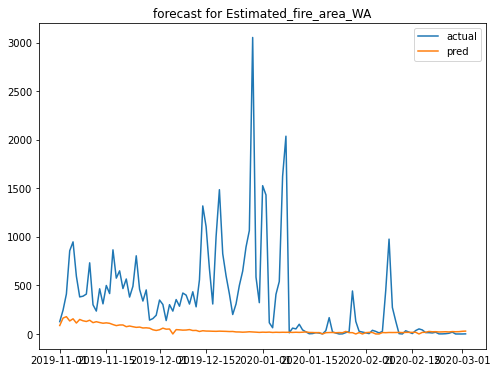

In [170]:
for i in fire_regions:

    plt.figure(figsize=(8,6))
    plt.plot(np.exp(test[:'2020-03'][i]) - 1, label = 'actual')
    plt.plot(np.exp(yhat_df[:'2020-03'][i]) - 1, label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

In [335]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())

mse = mean_squared_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 38.90290729013289, 'mse': 22997.828797146867}}

In [349]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())

mse = mean_squared_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 37.61219740369566, 'mse': 23569.307062687083}}

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = (np.exp(yhat_df['2020-02':][fire_regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][fire_regions].values)-1).flatten())

mse = mean_squared_error(y_true = (np.exp(yhat_df['2020-02':][fire_regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][fire_regions].values)-1).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 32.63632714983575, 'mse': 23245.925698827847}}

In [242]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = np.power(np.exp(yhat_df['2020-02':][sqrt_fire_regions].values)-1, 2).flatten(),
                   y_pred = np.power(np.exp(test['2020-02':][sqrt_fire_regions].values)-1, 2).flatten())

mse = mean_squared_error(y_true = np.power(np.exp(yhat_df['2020-02':][sqrt_fire_regions].values)-1, 2).flatten(),
                   y_pred = np.power(np.exp(test['2020-02':][sqrt_fire_regions].values)-1, 2).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 32.181879816855414, 'mse': 22984.509506718343}}

In [102]:
_results

{'dcnn_log1p': {'mae': 31.10491818762526, 'mse': 23585.2343689479}}

In [68]:
submission = np.exp(yhat_df['2020-02':'2020-02-28'][fire_regions])-1

In [350]:
submission = yhat_df['2020-02':'2020-02-28'][fire_regions]

In [351]:
submission

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2020-02-01,4.872530,16.290304,76.914148,19.893977,0.000000,23.908127,76.084201
2020-02-02,4.025656,23.735369,90.589854,23.487532,11.047121,16.285827,61.459896
2020-02-03,18.506602,51.645641,80.972067,24.013329,5.385706,21.382732,119.708074
2020-02-04,10.369689,48.859950,76.366904,0.000000,6.302943,28.132637,45.278764
2020-02-05,10.350995,17.703335,79.200445,10.995348,5.655730,24.478431,44.870076
2020-02-06,13.065515,50.335522,75.509145,8.041986,4.197926,28.485465,53.816033
2020-02-07,19.344893,0.677286,67.839734,8.646607,0.000000,21.937465,46.250313
2020-02-08,11.768787,48.010576,68.704283,14.024737,0.000000,16.893945,19.844584
2020-02-09,7.614478,0.000000,65.091977,0.000000,6.379442,22.420182,20.294774


In [352]:
submission = pd.melt(submission.reset_index(), id_vars = 'Date')

In [353]:
submission

,Date,variable,value
0,2020-02-01,Estimated_fire_area_NSW,4.872530
1,2020-02-02,Estimated_fire_area_NSW,4.025656
2,2020-02-03,Estimated_fire_area_NSW,18.506602
3,2020-02-04,Estimated_fire_area_NSW,10.369689
4,2020-02-05,Estimated_fire_area_NSW,10.350995
...,...,...,...
191,2020-02-24,Estimated_fire_area_WA,52.541951
192,2020-02-25,Estimated_fire_area_WA,52.417119
193,2020-02-26,Estimated_fire_area_WA,47.690596
194,2020-02-27,Estimated_fire_area_WA,49.066346


In [354]:
submission.rename(columns = {'variable': 'Region', 'value': 'Estimated_fire_area'}, inplace=True)

In [355]:
submission = pd.concat([submission[['Region']], submission[['Date']], submission['Estimated_fire_area']], axis = 1)

In [356]:
for i,x in zip(fire_regions, regions):
    submission['Region'].replace(to_replace = i, value = x, inplace=True)

In [357]:
submission

,Region,Date,Estimated_fire_area
0,NSW,2020-02-01,4.872530
1,NSW,2020-02-02,4.025656
2,NSW,2020-02-03,18.506602
3,NSW,2020-02-04,10.369689
4,NSW,2020-02-05,10.350995
...,...,...,...
191,WA,2020-02-24,52.541951
192,WA,2020-02-25,52.417119
193,WA,2020-02-26,47.690596
194,WA,2020-02-27,49.066346


In [358]:
submission.to_csv('Phase_1_sqrt_log4.csv', index= False,header=True)